# Modelo 

In [1]:
import numpy as np
import pandas as pd
import keras
from keras import layers
from keras.applications import VGG16
from keras.layers import Dense, Flatten, Dropout, BatchNormalization, Input, Concatenate
from keras.models import Model
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

/tmp/ipykernel_435155/1529197886.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-02-04 15:33:22.254282: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-04 15:33:22.539407: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has 

In [2]:
def global_branch(input_shape):
  densenet121 = tf.keras.applications.DenseNet121(input_shape= input_shape, include_top= False, weights="imagenet")
  densenet121._name= 'densenet121_global_branch'
  return densenet121

In [3]:
def local_branch(input_shape):
  densenet121 = tf.keras.applications.DenseNet121(input_shape= input_shape, include_top= False, weights="imagenet")
  densenet121._name= 'densenet121_local_branch'
  return densenet121

In [4]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Reshape, Dense, Permute, multiply
import tensorflow.keras.backend as K

def squeeze_excite_block(tensor, ratio=16):
    init = tensor
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    if K.image_data_format() == 'channels_first':
        se = Permute((3, 1, 2))(se)

    x = multiply([init, se])
    return x


In [5]:
img_shape= (224,224,3)
local_encoder = local_branch(img_shape)
global_encoder = global_branch(img_shape)

2024-02-04 15:33:33.205323: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-04 15:33:33.229978: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-04 15:33:33.230381: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-04 15:33:33.231267: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [22]:
def model_fusion(local_encoder, global_encoder):
#   global_encoder._name = "Level_1"
#   local_encoder._name = "Level_2"

  for layer in local_encoder.layers:
      layer._name = layer.name + str("_2")

  local_features = local_encoder.output
  global_features = global_encoder.output
  concatenated_volume = Concatenate(axis=-1)([local_features, global_features])

  se_block_out = squeeze_excite_block(concatenated_volume)
  # Clasification fusion
  x_F = layers.Flatten()(se_block_out)
  classification_fusion =  layers.Dense(15, activation="sigmoid")(x_F)

  fusion_model = Model(
      inputs=[local_encoder.input, global_encoder.input], outputs= [classification_fusion]
  )

  return fusion_model

In [23]:
f_model = model_fusion(local_encoder, global_encoder)

In [24]:
f_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1_2_2 (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1_2_2 (Conv2D)      (None, 224, 224, 64  1792        ['input_1_2_2[0][0]']            
                                )                                                           

# Batch

In [7]:
from keras.preprocessing.image import ImageDataGenerator


In [5]:
BATCH_SIZE=8

In [9]:
print("Número de GPUs disponíveis: ", len(
tf.config.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

Número de GPUs disponíveis:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-02-04 10:16:58.997625: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-04 10:16:59.018582: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-04 10:16:59.018975: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [11]:
df = pd.read_csv("/home/lucas/dataset_chest/df_ori_mask_crop.csv")
df

,Unnamed: 0,Image Index,Patient ID,Finding Labels,path,path_masks,Atelectasis,Cardiomegaly,Consolidation,Edema,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,path_crop
0,0,00015114_002.png,15114,Pleural_Thickening,/home/lucas/dataset_chest/dataset/images_06/im...,/home/lucas/dataset_chest/mask_chest/images_61...,0,0,0,0,...,0,0,0,0,0,0,1,0,0,/home/lucas/dataset_chest/mask_chest_crop/0001...
1,1,00013879_000.png,13879,No Finding,/home/lucas/dataset_chest/dataset/images_06/im...,/home/lucas/dataset_chest/mask_chest/images_55...,0,0,0,0,...,0,0,0,0,1,0,0,0,0,/home/lucas/dataset_chest/mask_chest_crop/0001...
2,2,00015087_002.png,15087,Atelectasis|Consolidation|Infiltration,/home/lucas/dataset_chest/dataset/images_06/im...,/home/lucas/dataset_chest/mask_chest/images_61...,1,0,1,0,...,0,0,1,0,0,0,0,0,0,/home/lucas/dataset_chest/mask_chest_crop/0001...
3,3,00015425_006.png,15425,No Finding,/home/lucas/dataset_chest/dataset/images_06/im...,/home/lucas/dataset_chest/mask_chest/images_62...,0,0,0,0,...,0,0,0,0,1,0,0,0,0,/home/lucas/dataset_chest/mask_chest_crop/0001...
4,4,00015427_000.png,15427,No Finding,/home/lucas/dataset_chest/dataset/images_06/im...,/home/lucas/dataset_chest/mask_chest/images_62...,0,0,0,0,...,0,0,0,0,1,0,0,0,0,/home/lucas/dataset_chest/mask_chest_crop/0001...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,69995,00011325_003.png,11325,No Finding,/home/lucas/dataset_chest/dataset/images_04/im...,/home/lucas/dataset_chest/mask_chest/images_43...,0,0,0,0,...,0,0,0,0,1,0,0,0,0,/home/lucas/dataset_chest/mask_chest_crop/0001...
69996,69996,00010352_060.png,10352,Effusion,/home/lucas/dataset_chest/dataset/images_04/im...,/home/lucas/dataset_chest/mask_chest/images_39...,0,0,0,0,...,0,0,0,0,0,0,0,0,0,/home/lucas/dataset_chest/mask_chest_crop/0001...
69997,69997,00009396_001.png,9396,No Finding,/home/lucas/dataset_chest/dataset/images_04/im...,/home/lucas/dataset_chest/mask_chest/images_35...,0,0,0,0,...,0,0,0,0,1,0,0,0,0,/home/lucas/dataset_chest/mask_chest_crop/0000...
69998,69998,00010590_000.png,10590,Atelectasis|Effusion,/home/lucas/dataset_chest/dataset/images_04/im...,/home/lucas/dataset_chest/mask_chest/images_40...,1,0,0,0,...,0,0,0,0,0,0,0,0,0,/home/lucas/dataset_chest/mask_chest_crop/0001...


In [1]:
from sklearn.model_selection import GroupShuffleSplit
def split_dataset():
    df = pd.read_csv('/home/lucas/dataset_chest/df_ori_mask_crop.csv')
    #split train/test 80/20
    split = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    groups = df['Patient ID'].values

    train_idxs, test_idxs = next(split.split(df, groups=groups))

    df_train = df.iloc[train_idxs]
    df_test = df.iloc[test_idxs]
    #split train/val -- 70/20/10
    split = GroupShuffleSplit(n_splits=1, test_size=0.125, random_state=42)
    groups = df_train['Patient ID'].values

    train_idxs, val_idxs = next(split.split(df_train, groups=groups))

    df_train_atualizado = df_train.iloc[train_idxs]
    df_val = df_train.iloc[val_idxs]
    return df_train_atualizado, df_test, df_val

In [4]:
df_train, df_test, df_val = split_dataset()


In [5]:
df_train

,Unnamed: 0,Image Index,Patient ID,Finding Labels,path,path_masks,Atelectasis,Cardiomegaly,Consolidation,Edema,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,path_crop
0,0,00015114_002.png,15114,Pleural_Thickening,/home/lucas/dataset_chest/dataset/images_06/im...,/home/lucas/dataset_chest/mask_chest/images_61...,0,0,0,0,...,0,0,0,0,0,0,1,0,0,/home/lucas/dataset_chest/mask_chest_crop/0001...
1,1,00013879_000.png,13879,No Finding,/home/lucas/dataset_chest/dataset/images_06/im...,/home/lucas/dataset_chest/mask_chest/images_55...,0,0,0,0,...,0,0,0,0,1,0,0,0,0,/home/lucas/dataset_chest/mask_chest_crop/0001...
2,2,00015087_002.png,15087,Atelectasis|Consolidation|Infiltration,/home/lucas/dataset_chest/dataset/images_06/im...,/home/lucas/dataset_chest/mask_chest/images_61...,1,0,1,0,...,0,0,1,0,0,0,0,0,0,/home/lucas/dataset_chest/mask_chest_crop/0001...
4,4,00015427_000.png,15427,No Finding,/home/lucas/dataset_chest/dataset/images_06/im...,/home/lucas/dataset_chest/mask_chest/images_62...,0,0,0,0,...,0,0,0,0,1,0,0,0,0,/home/lucas/dataset_chest/mask_chest_crop/0001...
5,5,00015896_002.png,15896,No Finding,/home/lucas/dataset_chest/dataset/images_06/im...,/home/lucas/dataset_chest/mask_chest/images_64...,0,0,0,0,...,0,0,0,0,1,0,0,0,0,/home/lucas/dataset_chest/mask_chest_crop/0001...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69991,69991,00010247_001.png,10247,Pneumothorax,/home/lucas/dataset_chest/dataset/images_04/im...,/home/lucas/dataset_chest/mask_chest/images_39...,0,0,0,0,...,0,0,0,0,0,0,0,0,1,/home/lucas/dataset_chest/mask_chest_crop/0001...
69992,69992,00011140_008.png,11140,Edema|Effusion,/home/lucas/dataset_chest/dataset/images_04/im...,/home/lucas/dataset_chest/mask_chest/images_43...,0,0,0,1,...,0,0,0,0,0,0,0,0,0,/home/lucas/dataset_chest/mask_chest_crop/0001...
69994,69994,00009237_002.png,9237,Infiltration,/home/lucas/dataset_chest/dataset/images_04/im...,/home/lucas/dataset_chest/mask_chest/images_35...,0,0,0,0,...,0,0,1,0,0,0,0,0,0,/home/lucas/dataset_chest/mask_chest_crop/0000...
69996,69996,00010352_060.png,10352,Effusion,/home/lucas/dataset_chest/dataset/images_04/im...,/home/lucas/dataset_chest/mask_chest/images_39...,0,0,0,0,...,0,0,0,0,0,0,0,0,0,/home/lucas/dataset_chest/mask_chest_crop/0001...


In [6]:
df_test

,Unnamed: 0,Image Index,Patient ID,Finding Labels,path,path_masks,Atelectasis,Cardiomegaly,Consolidation,Edema,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,path_crop
22,22,00015113_008.png,15113,No Finding,/home/lucas/dataset_chest/dataset/images_06/im...,/home/lucas/dataset_chest/mask_chest/images_61...,0,0,0,0,...,0,0,0,0,1,0,0,0,0,/home/lucas/dataset_chest/mask_chest_crop/0001...
25,25,00014719_003.png,14719,Mass,/home/lucas/dataset_chest/dataset/images_06/im...,/home/lucas/dataset_chest/mask_chest/images_59...,0,0,0,0,...,0,0,0,1,0,0,0,0,0,/home/lucas/dataset_chest/mask_chest_crop/0001...
28,28,00013992_029.png,13992,Atelectasis|Consolidation|Infiltration|Pneumonia,/home/lucas/dataset_chest/dataset/images_06/im...,/home/lucas/dataset_chest/mask_chest/images_55...,1,0,1,0,...,0,0,1,0,0,0,0,1,0,/home/lucas/dataset_chest/mask_chest_crop/0001...
35,35,00013939_000.png,13939,Infiltration,/home/lucas/dataset_chest/dataset/images_06/im...,/home/lucas/dataset_chest/mask_chest/images_55...,0,0,0,0,...,0,0,1,0,0,0,0,0,0,/home/lucas/dataset_chest/mask_chest_crop/0001...
37,37,00014106_015.png,14106,No Finding,/home/lucas/dataset_chest/dataset/images_06/im...,/home/lucas/dataset_chest/mask_chest/images_56...,0,0,0,0,...,0,0,0,0,1,0,0,0,0,/home/lucas/dataset_chest/mask_chest_crop/0001...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69972,69972,00011444_000.png,11444,No Finding,/home/lucas/dataset_chest/dataset/images_04/im...,/home/lucas/dataset_chest/mask_chest/images_44...,0,0,0,0,...,0,0,0,0,1,0,0,0,0,/home/lucas/dataset_chest/mask_chest_crop/0001...
69974,69974,00010863_003.png,10863,Effusion,/home/lucas/dataset_chest/dataset/images_04/im...,/home/lucas/dataset_chest/mask_chest/images_42...,0,0,0,0,...,0,0,0,0,0,0,0,0,0,/home/lucas/dataset_chest/mask_chest_crop/0001...
69985,69985,00010815_015.png,10815,Emphysema,/home/lucas/dataset_chest/dataset/images_04/im...,/home/lucas/dataset_chest/mask_chest/images_42...,0,0,0,0,...,0,0,0,0,0,0,0,0,0,/home/lucas/dataset_chest/mask_chest_crop/0001...
69993,69993,00010805_029.png,10805,No Finding,/home/lucas/dataset_chest/dataset/images_04/im...,/home/lucas/dataset_chest/mask_chest/images_41...,0,0,0,0,...,0,0,0,0,1,0,0,0,0,/home/lucas/dataset_chest/mask_chest_crop/0001...


In [7]:
df_val

,Unnamed: 0,Image Index,Patient ID,Finding Labels,path,path_masks,Atelectasis,Cardiomegaly,Consolidation,Edema,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,path_crop
3,3,00015425_006.png,15425,No Finding,/home/lucas/dataset_chest/dataset/images_06/im...,/home/lucas/dataset_chest/mask_chest/images_62...,0,0,0,0,...,0,0,0,0,1,0,0,0,0,/home/lucas/dataset_chest/mask_chest_crop/0001...
10,10,00013911_014.png,13911,No Finding,/home/lucas/dataset_chest/dataset/images_06/im...,/home/lucas/dataset_chest/mask_chest/images_55...,0,0,0,0,...,0,0,0,0,1,0,0,0,0,/home/lucas/dataset_chest/mask_chest_crop/0001...
11,11,00014197_022.png,14197,Infiltration,/home/lucas/dataset_chest/dataset/images_06/im...,/home/lucas/dataset_chest/mask_chest/images_57...,0,0,0,0,...,0,0,1,0,0,0,0,0,0,/home/lucas/dataset_chest/mask_chest_crop/0001...
26,26,00015746_000.png,15746,No Finding,/home/lucas/dataset_chest/dataset/images_06/im...,/home/lucas/dataset_chest/mask_chest/images_63...,0,0,0,0,...,0,0,0,0,1,0,0,0,0,/home/lucas/dataset_chest/mask_chest_crop/0001...
29,29,00014626_029.png,14626,Cardiomegaly|Edema|Infiltration|Nodule,/home/lucas/dataset_chest/dataset/images_06/im...,/home/lucas/dataset_chest/mask_chest/images_59...,0,1,0,1,...,0,0,1,0,0,1,0,0,0,/home/lucas/dataset_chest/mask_chest_crop/0001...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69946,69946,00010145_001.png,10145,Consolidation|Effusion|Infiltration,/home/lucas/dataset_chest/dataset/images_04/im...,/home/lucas/dataset_chest/mask_chest/images_38...,0,0,1,0,...,0,0,1,0,0,0,0,0,0,/home/lucas/dataset_chest/mask_chest_crop/0001...
69960,69960,00009485_004.png,9485,Mass,/home/lucas/dataset_chest/dataset/images_04/im...,/home/lucas/dataset_chest/mask_chest/images_35...,0,0,0,0,...,0,0,0,1,0,0,0,0,0,/home/lucas/dataset_chest/mask_chest_crop/0000...
69990,69990,00010634_007.png,10634,Nodule,/home/lucas/dataset_chest/dataset/images_04/im...,/home/lucas/dataset_chest/mask_chest/images_41...,0,0,0,0,...,0,0,0,0,0,1,0,0,0,/home/lucas/dataset_chest/mask_chest_crop/0001...
69995,69995,00011325_003.png,11325,No Finding,/home/lucas/dataset_chest/dataset/images_04/im...,/home/lucas/dataset_chest/mask_chest/images_43...,0,0,0,0,...,0,0,0,0,1,0,0,0,0,/home/lucas/dataset_chest/mask_chest_crop/0001...


In [12]:

labels = [
    "Atelectasis",
    "Cardiomegaly",
    "Consolidation",
    "Edema",
    "Effusion",
    "Emphysema",
    "Fibrosis",
    "Hernia",
    "Infiltration",
    "Mass",
    "No Finding",
    "Nodule",
    "Pleural_Thickening",
    "Pneumonia",
    "Pneumothorax"] 

In [33]:
def get_generator(df, x_col, batch_size=BATCH_SIZE, shuffle=False):
    datagen = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True)

    generator = datagen.flow_from_dataframe(
        dataframe=df,
        directory = None,
        x_col=x_col,
        y_col= labels,
        class_mode= "raw",
        target_size=(224,224),
        batch_size=BATCH_SIZE,
        shuffle=shuffle,
    )
    return generator



In [22]:
def generator_two_img(gen1, gen2):
    # genX3 = gen.flow(X3, y, batch_size=batch_size, seed=1)
    while True:
        X1i = gen1.next()
        X2i = gen2.next()
        # X3i = genX3.next()

        yield [X1i[0], X2i[0]], X1i[1]

In [49]:
train_global_gen = get_generator(df, x_col="path")

Found 70000 validated image filenames.


In [50]:
train_crop_gen = get_generator(df, x_col="path_crop")

Found 70000 validated image filenames.


In [51]:
train_two = generator_two_img(train_global_gen, train_crop_gen)

In [52]:
z = next(train_two)

In [53]:
global_batch = z[0][0]
local_batch = z[0][1]
y = z[1]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


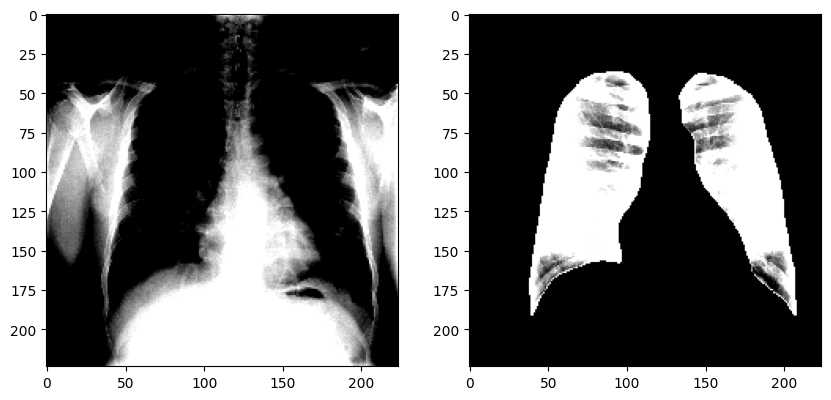

In [57]:
id_batch = 1
plt.figure(figsize=(10, 5))  # Ajuste o tamanho conforme necessário

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(global_batch[id_batch], cv2.COLOR_BGR2RGB))  # Converte de BGR para RGB para o matplotlib

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(local_batch[id_batch], cv2.COLOR_BGR2RGB))

plt.show()

# Re-train

In [6]:
BATCH_SIZE=16

import pandas as pd
import numpy as np
import os                                                                                                           
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from glob import glob
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import roc_auc_score
import tensorflow as tf
import utils
import uuid
from keras.layers import Dense, Flatten, Dropout, BatchNormalization, Input, Concatenate
from tensorflow.keras.layers import GlobalAveragePooling2D, Reshape, Dense, Permute, multiply
import tensorflow.keras.backend as K
from keras import layers

print("Número de GPUs disponíveis: ", len(
tf.config.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)


def split_dataset():
    df = pd.read_csv('/home/lucas/dataset_chest/df_ori_mask_crop.csv')
    split = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    groups = df['Patient ID'].values

    train_idxs, test_idxs = next(split.split(df, groups=groups))

    df_train = df.iloc[train_idxs]
    df_test = df.iloc[test_idxs]
    #split train/val -- 70/20/10
    split = GroupShuffleSplit(n_splits=1, test_size=0.125, random_state=42)
    groups = df_train['Patient ID'].values

    train_idxs, val_idxs = next(split.split(df_train, groups=groups))

    df_train_atualizado = df_train.iloc[train_idxs]
    df_val = df_train.iloc[val_idxs]
    return df_train_atualizado, df_test, df_val

def get_generator(df, x_col, batch_size=BATCH_SIZE, shuffle=False):
    datagen = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True)

    generator = datagen.flow_from_dataframe(
        dataframe=df,
        directory = None,
        x_col=x_col,
        y_col= labels,
        class_mode= "raw",
        target_size=(224,224),
        batch_size=BATCH_SIZE,
        shuffle=shuffle,
    )
    return generator

def generator_two_img(gen1, gen2):
    while True:
        X1i = gen1.next()
        X2i = gen2.next()
        # X3i = genX3.next()

        yield [X1i[0], X2i[0]], X1i[1]


df_train, df_test, df_val = split_dataset()

labels = [
    "Atelectasis",
    "Cardiomegaly",
    "Consolidation",
    "Edema",
    "Effusion",
    "Emphysema",
    "Fibrosis",
    "Hernia",
    "Infiltration",
    "Mass",
    "No Finding",
    "Nodule",
    "Pleural_Thickening",
    "Pneumonia",
    "Pneumothorax"] 

#generators global
train_generator_global = get_generator(df = df_train, x_col="path", shuffle=True)
val_generator_global = get_generator(df = df_val, x_col="path", shuffle=False)
test_generator_global = get_generator(df = df_test, x_col="path", shuffle=False)

#generators local 
train_generator_local = get_generator(df = df_train, x_col="path_crop", shuffle=True)
val_generator_local = get_generator(df = df_val, x_col="path_crop", shuffle=False,)
test_generator_local = get_generator(df = df_test, x_col="path_crop", shuffle=False,)


def compute_class_freqs(labels):
    """
    Compute positive and negative frequences for each class.

    Args:
        labels (np.array): matrix of labels, size (num_examples, num_classes)
    Returns:
        positive_frequencies (np.array): array of positive frequences for each
                                         class, size (num_classes)
        negative_frequencies (np.array): array of negative frequences for each
                                         class, size (num_classes)
    """

    # total number of patients (rows)
    N = labels.shape[0]

    positive_frequencies = np.sum(labels, axis=0) / N
    negative_frequencies = 1 - positive_frequencies

    return positive_frequencies, negative_frequencies


freq_pos, freq_neg = compute_class_freqs(train_generator_global.labels) #usando o generator global pra calcular a frequencia 
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights
neg_contribution = freq_neg * neg_weights

def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    """
    Return weighted loss function given negative weights and positive weights.

    Args:
      pos_weights (np.array): array of positive weights for each class, size (num_classes)
      neg_weights (np.array): array of negative weights for each class, size (num_classes)

    Returns:
      weighted_loss (function): weighted loss function
    """
    def weighted_loss(y_true, y_pred):
        """
        Return weighted loss value.

        Args:
            y_true (Tensor): Tensor of true labels, size is (num_examples, num_classes)
            y_pred (Tensor): Tensor of predicted labels, size is (num_examples, num_classes)
        Returns:
            loss (Float): overall scalar loss summed across all classes
        """
        # initialize loss to zero
        loss = 0.0
        y_true = tf.cast(y_true, tf.float32)

        for i in range(len(pos_weights)):

          loss += K.mean(-(pos_weights[i] *y_true[:,i] * K.log(y_pred[:,i] + epsilon)
          + neg_weights[i]* (1 - y_true[:,i]) * K.log( 1 - y_pred[:,i] + epsilon))) #complete this line
        return loss


    return weighted_loss

def global_branch(input_shape):
  densenet121 = tf.keras.applications.DenseNet121(input_shape= input_shape, include_top= False, weights="imagenet")
  densenet121._name= 'densenet121_global_branch'
  return densenet121

def local_branch(input_shape):
    densenet121 = tf.keras.applications.DenseNet121(input_shape= input_shape, include_top= False, weights="imagenet")
    densenet121._name= 'densenet121_local_branch'
    return densenet121

def squeeze_excite_block(tensor, ratio=16):
    init = tensor
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    if K.image_data_format() == 'channels_first':
        se = Permute((3, 1, 2))(se)

    x = multiply([init, se])
    return x

def model_fusion(local_encoder, global_encoder):
  for layer in local_encoder.layers:
      layer._name = layer.name + str("_2")

  local_features = local_encoder.output
  global_features = global_encoder.output
  concatenated_volume = Concatenate(axis=-1)([local_features, global_features])

  se_block_out = squeeze_excite_block(concatenated_volume)
  # Clasification fusion
  x_F = layers.Flatten()(se_block_out)
  classification_fusion =  layers.Dense(15, activation="sigmoid")(x_F)

  fusion_model = tf.keras.models.Model(
      inputs=[local_encoder.input, global_encoder.input], outputs= [classification_fusion]
  )

  return fusion_model

Número de GPUs disponíveis:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Physical devices cannot be modified after being initialized
Found 48621 validated image filenames.
Found 7073 validated image filenames.
Found 14306 validated image filenames.
Found 48621 validated image filenames.
Found 7073 validated image filenames.
Found 14306 validated image filenames.


In [3]:
# callbacks setup
MODEL_PATH = "records"
model_name = f"{uuid.uuid4()}"
CHECKPOINT_PATH = f"{MODEL_PATH}/{model_name}"
os.makedirs(CHECKPOINT_PATH, exist_ok=True)


early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=8,
    restore_best_weights=True
)

img_shape= (224,224,3)
# #classificador global
global_encoder = global_branch(img_shape)

# #classificador local
local_encoder = local_branch(img_shape)



2024-02-04 13:36:53.286909: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-04 13:36:53.287709: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-04 13:36:53.288136: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-04 13:36:53.288462: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [4]:
# classificador fusão
train_generator_global_2 = get_generator(df = df_train, x_col="path", shuffle=False)
train_generator_local_2 = get_generator(df = df_train, x_col="path_crop", shuffle=False)

train_two = generator_two_img(train_generator_global_2, train_generator_local_2)
val_two = generator_two_img(val_generator_global, val_generator_local)
test_two = generator_two_img(test_generator_global, test_generator_local)


Found 48621 validated image filenames.
Found 48621 validated image filenames.


In [5]:
f_model = model_fusion(local_encoder, global_encoder)
f_model.compile(optimizer='adam', loss=get_weighted_loss(pos_weights, neg_weights),  metrics=[tf.keras.metrics.AUC(multi_label=True)])

In [5]:
local_encoder.name, global_encoder.name

('densenet121_local_branch', 'densenet121_global_branch')

In [6]:
len(train_generator_global_2.labels)//BATCH_SIZE

3038

In [6]:
len(val_generator_global.labels)//1

7073

In [25]:
len(test_generator_global.labels)//BATCH_SIZE ### steps

894

In [32]:
import math

In [35]:
H_F = f_model.fit(train_two, 
    # validation_data = val_two,
    epochs = 1,
    steps_per_epoch = 10#len(train_generator_global_2.labels)//BATCH_SIZE,
    # validation_steps = len(val_generator_global.labels)//BATCH_SIZE,
)

utils.save_history(H_F.history, CHECKPOINT_PATH)
predictions = f_model.predict(test_two, verbose=1, steps=math.ceil(len(test_generator_global.labels)/BATCH_SIZE)) ## usando o generator como tamanho de steps


895/895 [==============================] - 198s 222ms/step


In [36]:
len(predictions)

14306

In [37]:
len(test_generator_global.labels)

14306

In [38]:
auc_scores = roc_auc_score(test_generator_global.labels, predictions, average=None)
auc_score_macro = roc_auc_score(test_generator_global.labels, predictions, average='macro')
auc_score_micro = roc_auc_score(test_generator_global.labels, predictions, average='micro')
auc_score_weighted = roc_auc_score(test_generator_global.labels, predictions, average='weighted')

results = {
    "groun_truth" : test_generator_global.labels,
    "predictions" : predictions,
    "auc_scores" : auc_scores,
    "labels" : labels,
    "auc_macro" : auc_score_macro,
    "auc_micro" : auc_score_micro,
    "auc_weighted" : auc_score_weighted,
}
utils.store_test_metrics(results, path=CHECKPOINT_PATH) #TODO ADD METRICA COM auc no nome

In [42]:
test_generator_global.labels

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [40]:
predictions

array([[1., 0., 1., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       ...,
       [1., 0., 1., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.]], dtype=float32)